Imports


In [33]:
from preprocess import prepare_loan_train_test, preprocess_loan_features
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from evaluate import plot_confusion_matrix, plot_feature_importance, plot_parameter_sensitivity, get_results, get_cross_validation_scores
from scipy.stats import randint, loguniform
import pandas as pd
import matplotlib.pylab as plt
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import numpy as np
from scipy.stats import randint, uniform
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
# df to save random search times
index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

## Base model with using SMOTE

In [12]:
training_data = pd.read_csv("loan-10k.lrn.csv")
training_data = preprocess_loan_features(training_data)

X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=True)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train.astype(str))
y_val_enc   = le.transform(y_val.astype(str))
class_names = le.classes_.tolist()  
n_classes   = len(class_names)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

X_train_sm = np.asarray(X_train_sm, dtype=np.float32)
X_val      = np.asarray(X_val,      dtype=np.float32)
y_train_sm = np.asarray(y_train_sm, dtype=np.int32)
y_val_enc  = np.asarray(y_val_enc,  dtype=np.int32)

target_names = class_names 


In [20]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

def build_model(input_dim, n_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(n_classes, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

base_model = build_model(X_train_sm.shape[1], n_classes=n_classes)

history = base_model.fit(
    X_train_sm,
    y_train_sm,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val_enc), 
    callbacks=[early_stopper],
    verbose=0
)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           A       0.93      0.90      0.91       364
           B       0.87      0.79      0.83       576
           C       0.77      0.87      0.82       598
           D       0.73      0.69      0.71       290
           E       0.54      0.54      0.54       124
           F       0.31      0.27      0.29        37
           G       0.27      0.27      0.27        11

    accuracy                           0.79      2000
   macro avg       0.63      0.62      0.62      2000
weighted avg       0.79      0.79      0.79      2000



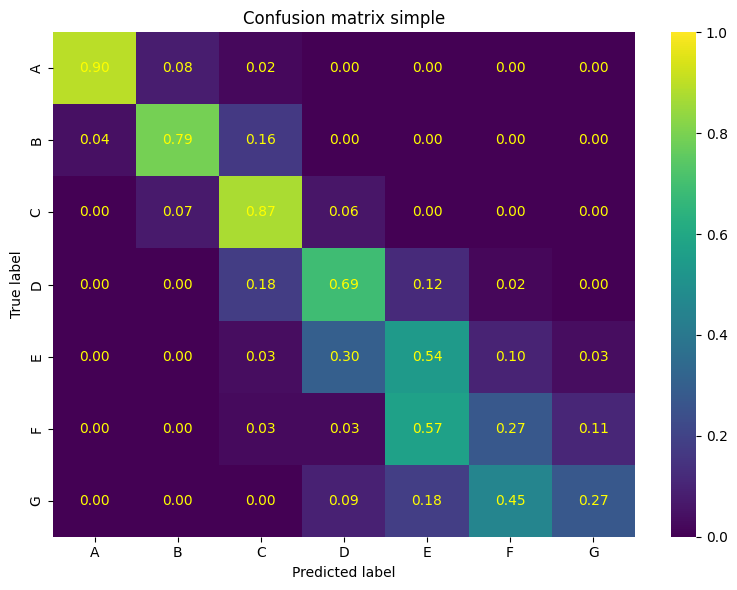

In [21]:
y_pred_enc = base_model.predict(X_val).argmax(axis=1)
y_pred_str = le.inverse_transform(y_pred_enc)
y_val_str  = le.inverse_transform(y_val_enc)

get_results(y_val_str, y_pred_str, target_names=target_names, plot_cm=True)

In [49]:
model_name = 'mlp_smote'

n_classes = len(np.unique(y_train))

param_distributions = {
    'model__hidden_units': randint(50, 200), 
    'model__activation': ['relu', 'tanh'],   
    'optimizer__learning_rate': uniform(loc=0.0001, scale=0.01), 
    
    'batch_size': [16, 32, 64],  
    'epochs': [50, 100, 150],       
}

def build_model_tune(input_dim, n_classes, hidden_units=100, activation='relu', learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(hidden_units, activation=activation),
        Dense(n_classes, activation='softmax')  
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(
    model=build_model_tune,
    model__input_dim=X_train_sm.shape[1],
    model__n_classes=n_classes,         
    callbacks=[early_stopper],
    verbose=0,
    validation_split=0.1
)


random_search_keras = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions= param_distributions,
    n_iter=30,       
    scoring='f1_weighted',
    cv=3,          
    random_state=42,
    n_jobs=-1        
)

start_time = time.time()
random_search_keras.fit(X_train_sm, y_train_sm)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time

print(f"Best F1 Weighted Score: {random_search_keras.best_score_:.4f}")
print(f"Best Hyperparameters: {random_search_keras.best_params_}")

2025-11-10 00:43:27.563894: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 00:43:27.565060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 00:43:27.771192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 00:43:27.771840: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 00:43:27.772355: I tensorflow/core/util/port.cc:153] oneDNN custom 

Best F1 Weighted Score: 0.7810
Best Hyperparameters: {'batch_size': 16, 'epochs': 150, 'model__activation': 'tanh', 'model__hidden_units': 124, 'optimizer__learning_rate': np.float64(0.004692488919658672)}


              precision    recall  f1-score   support

           A       0.92      0.88      0.90       364
           B       0.85      0.80      0.82       576
           C       0.81      0.79      0.80       598
           D       0.67      0.70      0.69       290
           E       0.50      0.50      0.50       124
           F       0.19      0.46      0.27        37
           G       0.38      0.27      0.32        11

    accuracy                           0.77      2000
   macro avg       0.62      0.63      0.61      2000
weighted avg       0.79      0.77      0.78      2000



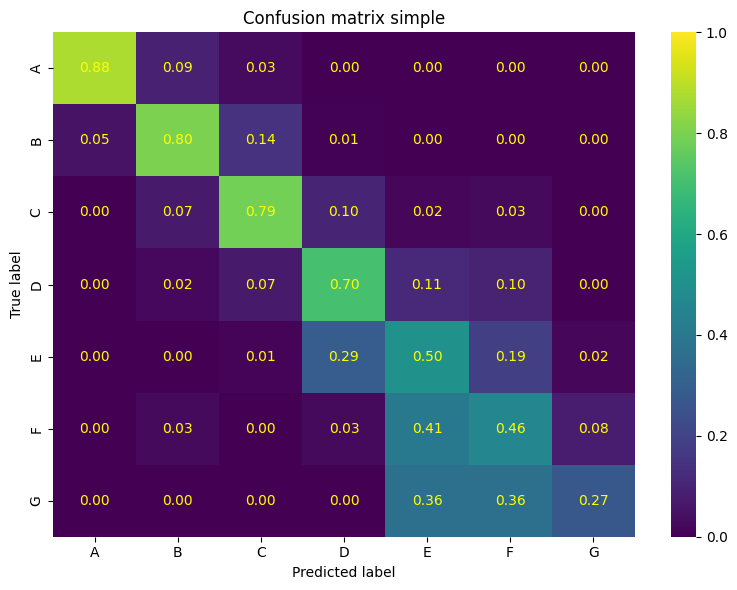

In [ ]:
best_clf = random_search_keras.best_estimator_
Xv = X_val.astype(np.float32, copy=False)
y_pred_optimized = best_clf.predict(Xv)

if np.issubdtype(np.array(y_pred_optimized).dtype, np.number):
    y_pred_optimized = np.array([target_names[int(i)] for i in y_pred_optimized])

get_results(y_val, y_pred_optimized, target_names)


## Base model without SMOTE

In [43]:
training_data = pd.read_csv("loan-10k.lrn.csv")
training_data = preprocess_loan_features(training_data)

X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=True)

In [45]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

def build_model(input_dim, n_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(n_classes, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

base_model = build_model(X_train.shape[1], n_classes=n_classes)

history = base_model.fit(
    X_train,
    y_train_enc,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val_enc),
    callbacks=[early_stopper],
    verbose=0
)


 1/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           A       0.93      0.86      0.89       364
           B       0.76      0.85      0.80       576
           C       0.74      0.81      0.77       598
           D       0.72      0.59      0.65       290
           E       0.55      0.51      0.53       124
           F       0.42      0.14      0.20        37
           G       0.00      0.00      0.00        11

    accuracy                           0.76      2000
   macro avg       0.59      0.54      0.55      2000
weighted avg       0.76      0.76      0.76      2000



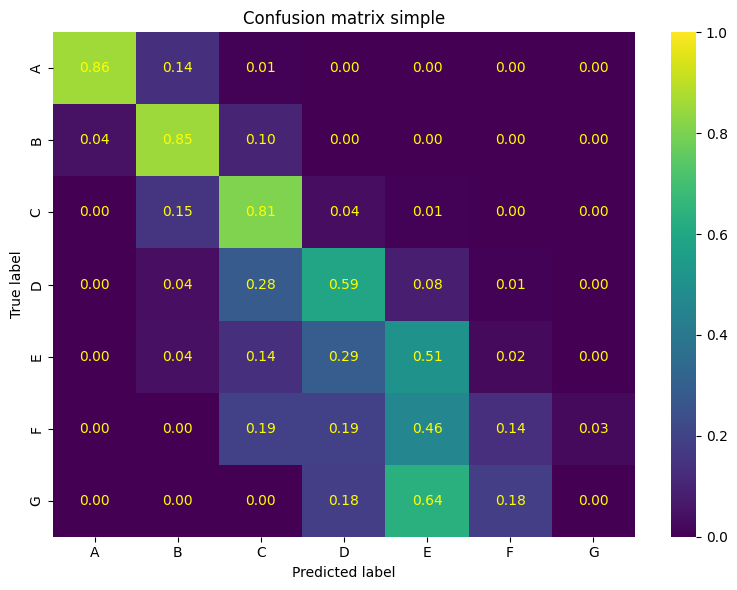

In [47]:
y_pred_enc = base_model.predict(X_val).argmax(axis=1)
y_pred_str = le.inverse_transform(y_pred_enc)
y_val_str  = le.inverse_transform(y_val_enc)

get_results(y_val_str, y_pred_str, target_names=target_names, plot_cm=True)

In [54]:
model_name = 'mlp_nosmote'

n_classes = len(np.unique(y_train))

param_distributions = {
    'model__hidden_units': randint(50, 200), 
    'model__activation': ['relu', 'tanh'],   
    'optimizer__learning_rate': uniform(loc=0.0001, scale=0.01), 
    
    'batch_size': [16, 32, 64],  
    'epochs': [50, 100, 150],       
}

def build_model_tune(input_dim, n_classes, hidden_units=100, activation='relu', learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(hidden_units, activation=activation),
        Dense(n_classes, activation='softmax')  
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(
    model=build_model_tune,
    model__input_dim=X_train.shape[1],
    model__n_classes=n_classes,         
    callbacks=[early_stopper],
    verbose=0,
    validation_split=0.1
)


random_search_keras = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions= param_distributions,
    n_iter=12,       
    scoring='f1_weighted',
    cv=3,          
    random_state=42,
    n_jobs=-1        
)

start_time = time.time()
random_search_keras.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time

print(f"Best F1 Weighted Score: {random_search_keras.best_score_:.4f}")
print(f"Best Hyperparameters: {random_search_keras.best_params_}")

2025-11-10 01:13:30.801360: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 01:13:30.803084: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 01:13:30.969311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 01:13:31.501679: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 01:13:31.502706: I tensorflow/core/util/port.cc:153] oneDNN custom 

Best F1 Weighted Score: 0.7798
Best Hyperparameters: {'batch_size': 32, 'epochs': 100, 'model__activation': 'tanh', 'model__hidden_units': 70, 'optimizer__learning_rate': np.float64(0.0062748150962771655)}


              precision    recall  f1-score   support

           A       0.93      0.91      0.92       364
           B       0.88      0.79      0.83       576
           C       0.71      0.89      0.79       598
           D       0.71      0.69      0.70       290
           E       0.61      0.43      0.50       124
           F       0.73      0.22      0.33        37
           G       0.00      0.00      0.00        11

    accuracy                           0.79      2000
   macro avg       0.65      0.56      0.58      2000
weighted avg       0.79      0.79      0.78      2000



/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/anaconda3/envs/tf311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

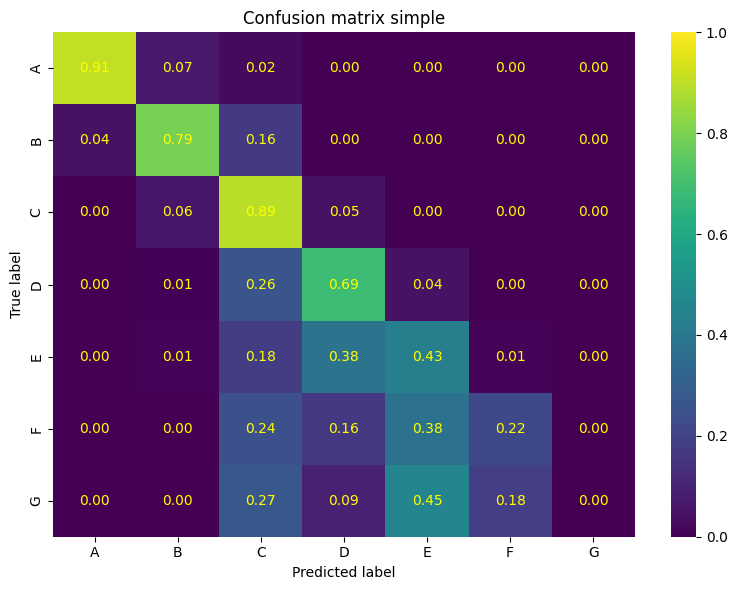

In [55]:
best_clf = random_search_keras.best_estimator_
y_pred_optimized = best_clf.predict(X_val)

get_results(y_val, y_pred_optimized, target_names)


## Unscaled data

In [56]:
training_data = pd.read_csv("loan-10k.lrn.csv")
training_data = preprocess_loan_features(training_data)

X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=False)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train.astype(str))
y_val_enc   = le.transform(y_val.astype(str))
class_names = le.classes_.tolist()  
n_classes   = len(class_names)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

X_train_sm = np.asarray(X_train_sm, dtype=np.float32)
X_val      = np.asarray(X_val,      dtype=np.float32)
y_train_sm = np.asarray(y_train_sm, dtype=np.int32)
y_val_enc  = np.asarray(y_val_enc,  dtype=np.int32)

target_names = class_names 


In [57]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

def build_model(input_dim, n_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(n_classes, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

base_model = build_model(X_train_sm.shape[1], n_classes=n_classes)

history = base_model.fit(
    X_train_sm,
    y_train_sm,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val_enc), 
    callbacks=[early_stopper],
    verbose=0
)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           A       0.44      0.02      0.04       364
           B       0.30      0.01      0.02       576
           C       0.00      0.00      0.00       598
           D       0.00      0.00      0.00       290
           E       0.25      0.01      0.02       124
           F       0.00      0.00      0.00        37
           G       0.01      1.00      0.01        11

    accuracy                           0.01      2000
   macro avg       0.14      0.15      0.01      2000
weighted avg       0.18      0.01      0.01      2000



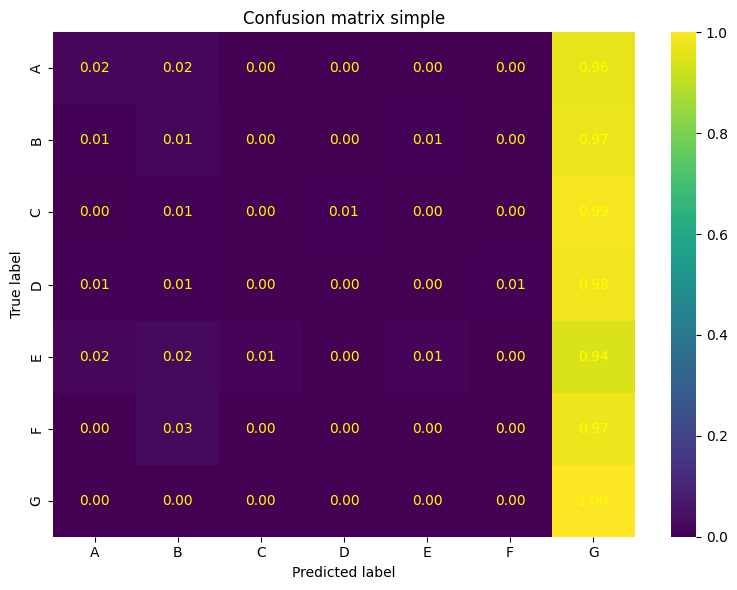

In [58]:
y_pred_enc = base_model.predict(X_val).argmax(axis=1)
y_pred_str = le.inverse_transform(y_pred_enc)
y_val_str  = le.inverse_transform(y_val_enc)

get_results(y_val_str, y_pred_str, target_names=target_names, plot_cm=True)

In [59]:
model_name = 'mlp_smote'

n_classes = len(np.unique(y_train))

param_distributions = {
    'model__hidden_units': randint(50, 200), 
    'model__activation': ['relu', 'tanh'],   
    'optimizer__learning_rate': uniform(loc=0.0001, scale=0.01), 
    
    'batch_size': [16, 32, 64],  
    'epochs': [50, 100, 150],       
}

def build_model_tune(input_dim, n_classes, hidden_units=100, activation='relu', learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(hidden_units, activation=activation),
        Dense(n_classes, activation='softmax')  
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(
    model=build_model_tune,
    model__input_dim=X_train_sm.shape[1],
    model__n_classes=n_classes,         
    callbacks=[early_stopper],
    verbose=0,
    validation_split=0.1
)


random_search_keras = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions= param_distributions,
    n_iter=12,       
    scoring='f1_weighted',
    cv=3,          
    random_state=42,
    n_jobs=-1        
)

start_time = time.time()
random_search_keras.fit(X_train_sm, y_train_sm)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time

print(f"Best F1 Weighted Score: {random_search_keras.best_score_:.4f}")
print(f"Best Hyperparameters: {random_search_keras.best_params_}")

2025-11-10 01:23:01.031945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 01:23:01.032714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 01:23:01.331655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 01:23:07.777647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Best F1 Weighted Score: 0.1568
Best Hyperparameters: {'batch_size': 64, 'epochs': 100, 'model__activation': 'relu', 'model__hidden_units': 157, 'optimizer__learning_rate': np.float64(0.0052423443841361165)}


              precision    recall  f1-score   support

           A       0.44      0.29      0.35       364
           B       0.31      0.20      0.24       576
           C       0.33      0.24      0.28       598
           D       0.12      0.21      0.16       290
           E       0.10      0.31      0.15       124
           F       0.17      0.14      0.15        37
           G       0.05      0.18      0.08        11

    accuracy                           0.23      2000
   macro avg       0.22      0.22      0.20      2000
weighted avg       0.30      0.23      0.25      2000



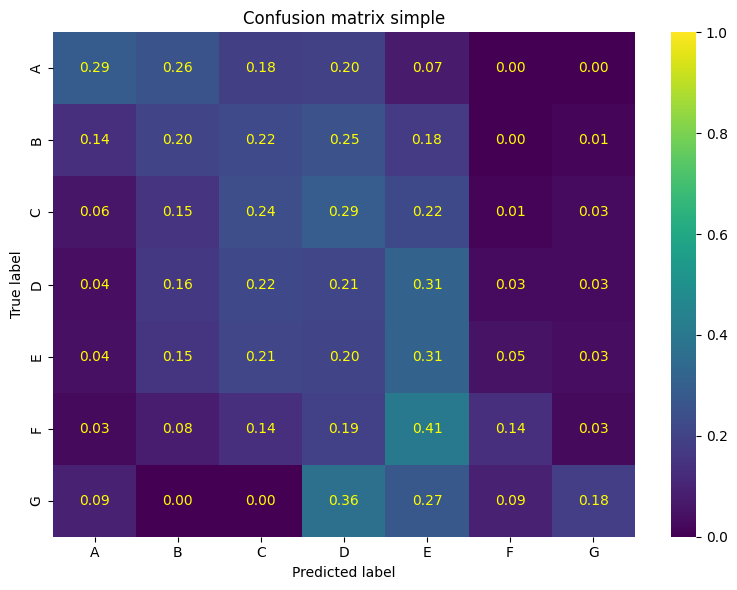

In [60]:
best_clf = random_search_keras.best_estimator_
Xv = X_val.astype(np.float32, copy=False)
y_pred_optimized = best_clf.predict(Xv)

if np.issubdtype(np.array(y_pred_optimized).dtype, np.number):
    y_pred_optimized = np.array([target_names[int(i)] for i in y_pred_optimized])

get_results(y_val, y_pred_optimized, target_names)
